In [3]:
#! IBM Skills Network App Skeleton (from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/spacex_dash_app.py)
'''
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
spacex_df: pd.DataFrame = pd.read_csv('spacex_launch_dash.csv')
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(
    children=[
        html.H1(
            'SpaceX Launch Records Dashboard',
            style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40},
        ),
        # TASK 1: Add a dropdown list to enable Launch Site selection
        # The default select value is for ALL sites
        # dcc.Dropdown(id='site-dropdown',...)
        html.Br(),
        # TASK 2: Add a pie chart to show the total successful launches count for all sites
        # If a specific launch site was selected, show the Success vs. Failed counts for the site
        html.Div(dcc.Graph(id='success-pie-chart')),
        html.Br(),
        html.P('Payload range (Kg):'),
        # TASK 3: Add a slider to select payload range
        # dcc.RangeSlider(id='payload-slider',...)
        # TASK 4: Add a scatter chart to show the correlation between payload and launch success
        html.Div(dcc.Graph(id='success-payload-scatter-chart')),
    ]
)

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output


# Run the app
if __name__ == '__main__':
    app.run_server()
'''
print()

In [5]:
import pandas as pd
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px
import requests
from io import StringIO

URL: str = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv'
response: requests.Response = requests.get(URL)
spacex_df: pd.DataFrame = pd.read_csv(StringIO(response.text))
spacex_df.drop('Unnamed: 0', axis=1, inplace=True)

max_payload: float = spacex_df['Payload Mass (kg)'].max()
min_payload: float = spacex_df['Payload Mass (kg)'].min()

spacex_df.head()

,Flight Number,Launch Site,class,Payload Mass (kg),Booster Version,Booster Version Category
0,1,CCAFS LC-40,0,0.0,F9 v1.0 B0003,v1.0
1,2,CCAFS LC-40,0,0.0,F9 v1.0 B0004,v1.0
2,3,CCAFS LC-40,0,525.0,F9 v1.0 B0005,v1.0
3,4,CCAFS LC-40,0,500.0,F9 v1.0 B0006,v1.0
4,5,CCAFS LC-40,0,677.0,F9 v1.0 B0007,v1.0


In [57]:
# Create a dash application
from plotly.graph_objs._figure import Figure


app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(
    children=[
        html.H1(
            "SpaceX Launch Records Dashboard",
            style={"textAlign": "center", "color": "black", "font-size": 40},
        ),
        # TASK 1: Add a dropdown list to enable Launch Site selection
        # The default select value is for ALL sites
        dcc.Dropdown(
            id="site-dropdown",
            options=[
                {"label": "All Sites", "value": "ALL"},
                {"label": "CCAFS LC-40", "value": "CCAFS LC-40"},
                {"label": "VAFB SLC-4E", "value": "VAFB SLC-4E"},
                {"label": "KSC LC-39A", "value": "KSC LC-39A"},
                {"label": "CCAFS SLC-40", "value": "CCAFS SLC-40"},
            ],
            value="ALL",
            placeholder="Select a Launch Site here",
            searchable=True,
        ),
        html.Br(),
        # TASK 2: Add a pie chart to show the total successful launches count for all sites
        # If a specific launch site was selected, show the Success vs. Failed counts for the site
        html.Div(dcc.Graph(id="success-pie-chart")),
        html.Br(),
        html.P("Payload range (Kg):"),
        # TASK 3: Add a slider to select payload range
        dcc.RangeSlider(
            id='payload-slider',
            min=0,
            max=10000,
            step=1000, 
            value=[min_payload, max_payload]
            ),
        # TASK 4: Add a scatter chart to show the correlation between payload and launch success
        html.Div(dcc.Graph(id="success-payload-scatter-chart")),
    ]
)

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site) -> Figure:
    filtered_df: pd.DataFrame = spacex_df.copy()
    class_color_map: dict[int, str] = {1: 'forestgreen', 0:'crimson'}

    if entered_site == 'ALL':
        fig: Figure = px.pie(
            filtered_df,
            names="Launch Site",
            values="class",
            title=f"Total Success Launches per Site: {filtered_df['class'].value_counts()[1]}"
        )
    elif entered_site != 'ALL' and entered_site is not None:
        filtered_df = filtered_df[filtered_df['Launch Site'] == entered_site]
        fig: Figure = px.pie(
            filtered_df,
            names="class",
            color="class",
            color_discrete_map=class_color_map,
            title=f"Total Launch Outcomes for Launch Site {entered_site}: {sum(filtered_df['class'].value_counts())}",
        )
    else:
        fig: Figure = px.pie(title='Please enter a launch site')

    fig.update_traces(textinfo="value + percent")
    return fig

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(
    Output(component_id='success-payload-scatter-chart', component_property='figure'),
    Input(component_id='site-dropdown', component_property='value'),
    Input(component_id='payload-slider', component_property='value')
)
def get_scatterplot(entered_site, entered_range) -> Figure:
    filtered_df: pd.DataFrame = spacex_df.copy()
    booster_version_cat_color_map: dict[str, str] = {
    cat: col
    for cat, col in zip(
        spacex_df["Booster Version Category"].unique(),
        ["blue", "red", "green", "purple", "orange"],
    )
}
    filtered_df = filtered_df[
        (filtered_df["Payload Mass (kg)"] >= entered_range[0])
        & (filtered_df["Payload Mass (kg)"] <= entered_range[1])
    ]

    if entered_site == "ALL":

        fig: Figure = px.scatter(
            filtered_df,
            x="Payload Mass (kg)",
            y="class",
            color_discrete_map=booster_version_cat_color_map,
            color="Booster Version Category",
            title="Total Launch Outcomes vs. Payload Mass (kg)",
        )

    elif entered_site != "ALL" and entered_site is not None:
        filtered_df = filtered_df[filtered_df["Launch Site"] == entered_site]
        fig: Figure = px.scatter(
            filtered_df,
            x="Payload Mass (kg)",
            y="class",
            color_discrete_map=booster_version_cat_color_map,
            color="Booster Version Category",
            title=f"Launch Outcomes vs. Payload Mass (kg) for Launch Site {entered_site}",
        )
    else:
        fig: Figure = px.scatter(title="Please enter a launch site")
    return fig
# Run the app
if __name__ == '__main__':
    app.run_server(port=8080)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



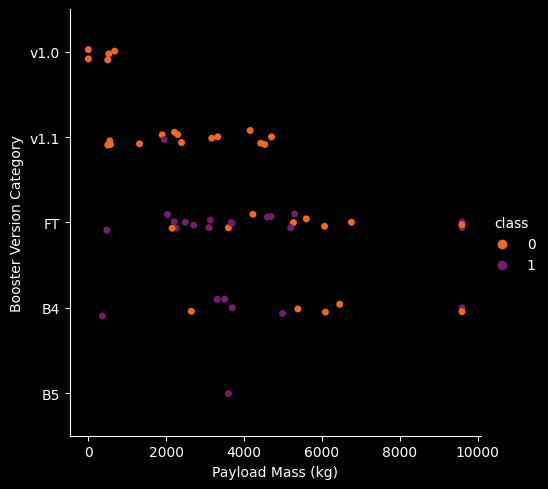

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')
sns.catplot(
    spacex_df,
    x="Payload Mass (kg)",
    y="Booster Version Category",
    aspect=1,
    hue='class',
    palette='inferno_r',
    
)
plt.show()

Questions:
1. Which site has the largest successful launches?
2. Which site has the highest launch success rate?
3. Which payload range(s) has the highest launch success rate?
4. Which payload range(s) has the lowest launch success rate?
5. Which F9 Booster version (v1.0, v1.1, FT, B4, B5, etc.) has the highest
launch success rate?

Answers:

1. CCAFS LC-40
2. KSC LC-39A
3. 1,952kg - 5,300kg
4. 4,159kg - 6,761kg
5. FT